# Funding Rates + Open Interest/Volume

This notebook collects funding rate historical data for Binance, Bybit and Hyperliquid since listing for a given symbol, which we choose based from the list of all listings sorted by the first letter. 

In [3]:
import requests
from pybit.unified_trading import HTTP

# Initialize Bybit session (real endpoint, not testnet)
bybit_session = HTTP(testnet=False)

def list_binance_symbols():
    url = "https://fapi.binance.com/fapi/v1/exchangeInfo"
    try:
        response = requests.get(url, timeout=10)
        data = response.json()
        return sorted([s["symbol"] for s in data["symbols"] if s.get("contractType") == "PERPETUAL"])
    except Exception as e:
        print(f"Binance symbol fetch error: {e}")
        return []

def list_bybit_symbols(bybit_session):
    try:
        response = bybit_session.get_instruments_info(category="linear")
        return sorted([item["symbol"] for item in response["result"]["list"]])
    except Exception as e:
        print(f"Bybit symbol fetch error: {e}")
        return []

def list_hyperliquid_symbols():
    url = "https://api.hyperliquid.xyz/info"
    payload = {"type": "meta"}
    try:
        response = requests.post(url, json=payload, timeout=10)
        data = response.json()
        return sorted([coin["name"] for coin in data["universe"]])
    except Exception as e:
        print(f"Hyperliquid symbol fetch error: {e}")
        return []

# --- Helper function to filter by starting letter ---
def prompt_symbol(exchange_name, symbols):
    if not symbols:
        print(f"⚠️ No symbols available for {exchange_name}.")
        return None

    letter = input(f"\n🔤 Enter starting letter for {exchange_name} symbol (or press Enter to skip): ").strip().upper()
    if letter:
        filtered = [s for s in symbols if s.startswith(letter)]
    else:
        print(f"ℹ️ Skipping {exchange_name}.")
        return None

    if not filtered:
        print(f"❌ No {exchange_name} symbols found starting with '{letter}'. Skipping exchange.")
        return None

    print(f"\n--- {exchange_name} Symbols starting with '{letter}' ---")
    print(", ".join(filtered[:50]) + (" ..." if len(filtered) > 50 else ""))
    
    selected = input(f"✅ Enter your desired {exchange_name} symbol (or press Enter to skip): ").strip().upper()
    if not selected:
        print(f"ℹ️ Skipping {exchange_name}.")
        return None

    if selected in symbols:
        return selected
    else:
        print(f"❌ '{selected}' not in {exchange_name} list. Skipping.")
        return None


# --- Fetch and prompt ---
print("📦 Fetching available symbols...")

binance_symbols = list_binance_symbols()
bybit_symbols = list_bybit_symbols(bybit_session)
hyperliquid_symbols = list_hyperliquid_symbols()

symbol_binance = prompt_symbol("Binance", binance_symbols)
symbol_bybit = prompt_symbol("Bybit", bybit_symbols)
symbol_hyperliquid = prompt_symbol("Hyperliquid", hyperliquid_symbols)


📦 Fetching available symbols...

--- Binance Symbols starting with 'L' ---
LAYERUSDT, LDOUSDT, LEVERUSDT, LINAUSDT, LINKUSDC, LINKUSDT, LISTAUSDT, LITUSDT, LOKAUSDT, LOOMUSDT, LPTUSDT, LQTYUSDT, LRCUSDT, LSKUSDT, LTCUSDC, LTCUSDT, LUMIAUSDT, LUNA2USDT

--- Bybit Symbols starting with 'L' ---
L3USDT, LDOUSDT, LEVERUSDT, LINKPERP, LINKUSDT, LISTAUSDT, LOOKSUSDT, LPTUSDT, LQTYUSDT, LRCUSDT, LSKUSDT, LTCPERP, LTCUSDT, LUMIAUSDT, LUNA2USDT
ℹ️ Skipping Bybit.

--- Hyperliquid Symbols starting with 'L' ---
LAYER, LDO, LINK, LISTA, LOOM, LTC


🔎 Selected Symbols:
  Binance      : LAYERUSDT
  Bybit        : ❌ Skipped
  Hyperliquid  : LAYER
Binance LAYERUSDT listed on 2025-02-11 15:45:00
Binance Fetch Complete ✅ Total funding entries: 506
No data between 2023-12-03 00:00:00 and 2023-12-10 00:00:00
No data between 2023-12-10 00:00:00.001000 and 2023-12-17 00:00:00.001000
No data between 2023-12-17 00:00:00.002000 and 2023-12-24 00:00:00.002000
No data between 2023-12-24 00:00:00.003000 and 2023-12-31 00:00:00.003000
No data between 2023-12-31 00:00:00.004000 and 2024-01-07 00:00:00.004000
No data between 2024-01-07 00:00:00.005000 and 2024-01-14 00:00:00.005000
No data between 2024-01-14 00:00:00.006000 and 2024-01-21 00:00:00.006000
No data between 2024-01-21 00:00:00.007000 and 2024-01-28 00:00:00.007000
No data between 2024-01-28 00:00:00.008000 and 2024-02-04 00:00:00.008000
No data between 2024-02-04 00:00:00.009000 and 2024-02-11 00:00:00.009000
No data between 2024-02-11 00:00:00.010000 and 2024-02-18 00:00:00.010000
No 

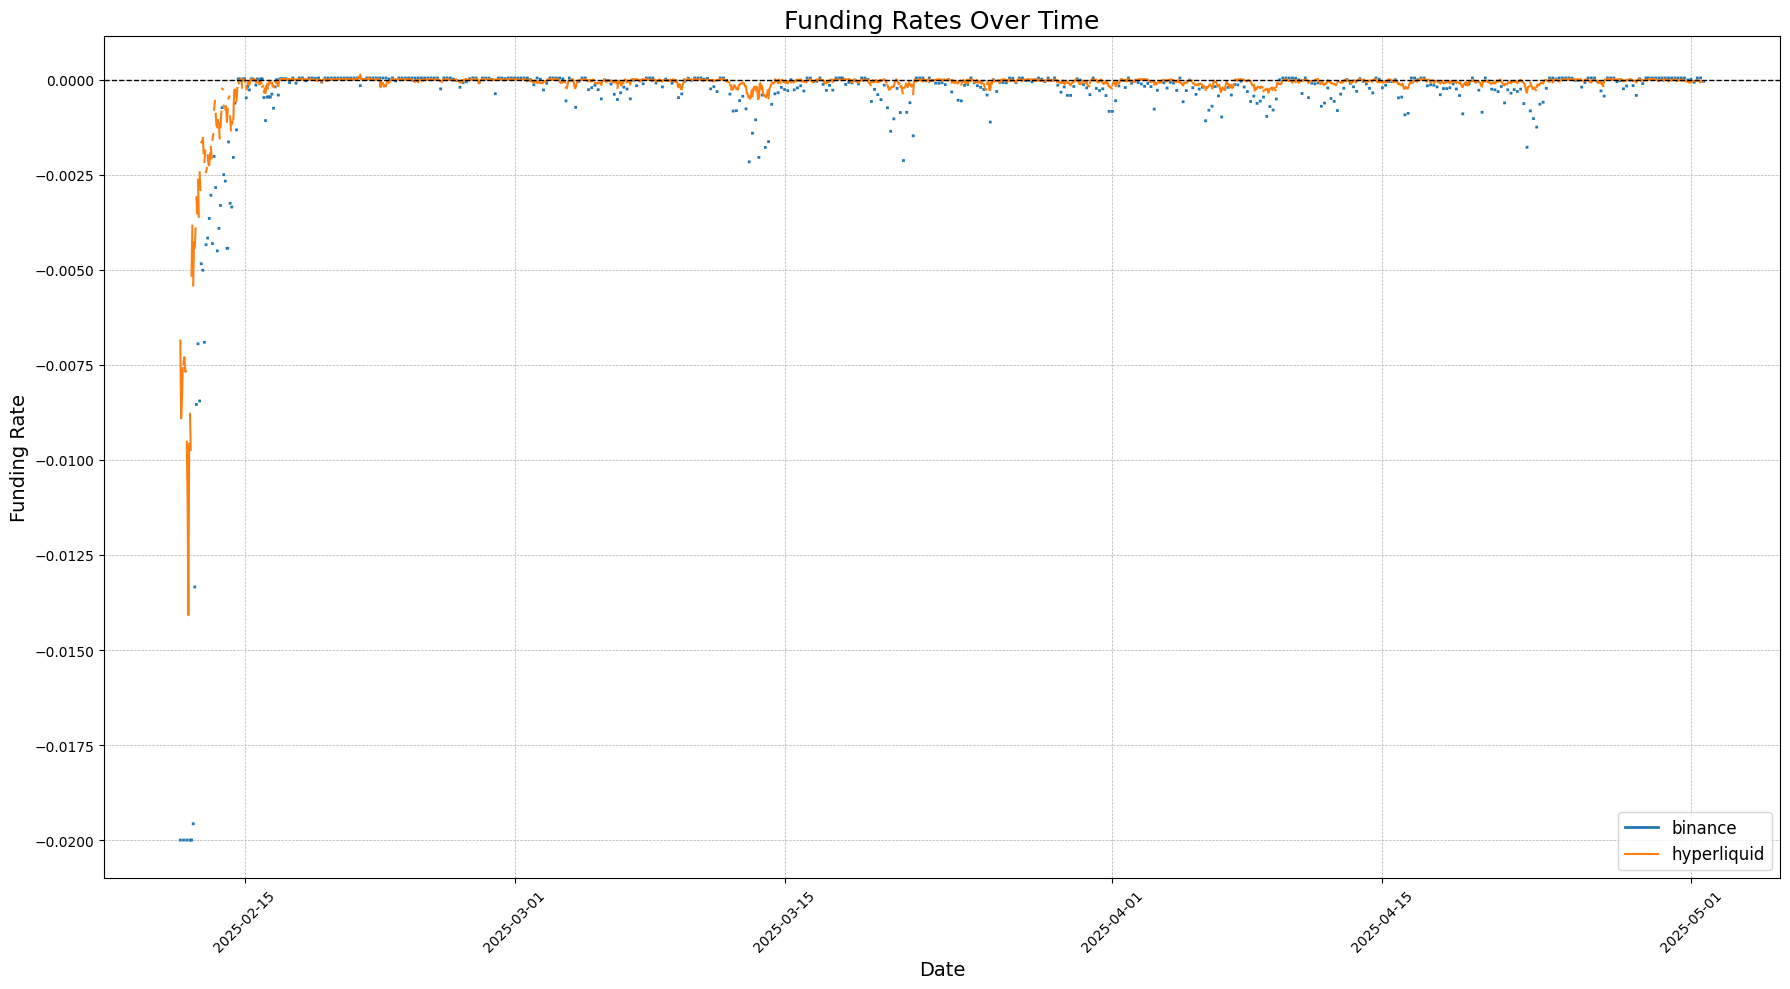


📈 Current Open Interest and 24h Volume:
Binance      OI: 22,945,970   Volume (24h): 53,590,447
Hyperliquid  OI: 3,357,086   Volume (24h): 3,569,933


In [ ]:
import requests
import time
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pybit.unified_trading import HTTP

# Initialize Bybit session
bybit_session = HTTP(testnet=False)
# Function to fetch current Open Interest and 24h Volume
def fetch_oi_and_volume(symbol_binance=None, symbol_bybit=None, symbol_hyperliquid=None):
    result = {}

    # Binance
    if symbol_binance:
        try:
            # Volume
            url_volume = f"https://fapi.binance.com/fapi/v1/ticker/24hr?symbol={symbol_binance}"
            vol_response = requests.get(url_volume, timeout=10)
            vol_response.raise_for_status()
            vol_data = vol_response.json()
            volume = float(vol_data.get("volume", 0))

            # Open Interest (separate endpoint)
            url_oi = f"https://fapi.binance.com/fapi/v1/openInterest?symbol={symbol_binance}"
            oi_response = requests.get(url_oi, timeout=10)
            oi_response.raise_for_status()
            oi_data = oi_response.json()
            open_interest = float(oi_data.get("openInterest", 0))

            result["binance"] = {
                "open_interest": open_interest,
                "volume_24h": volume
            }
        except Exception as e:
            print(f"Binance OI fetch error: {e}")

    # Bybit
    if symbol_bybit:
        try:
            tickers = bybit_session.get_tickers(category="linear")
            match = next((x for x in tickers["result"]["list"] if x["symbol"] == symbol_bybit), None)
            if match:
                result["bybit"] = {
                    "open_interest": float(match.get("openInterest", 0)),
                    "volume_24h": float(match.get("turnover24h", 0))
                }
        except Exception as e:
            print(f"Bybit OI fetch error: {e}")

    # Hyperliquid
    
    if symbol_hyperliquid:
        try:
            url = "https://api.hyperliquid.xyz/info"
            payload = {"type": "metaAndAssetCtxs"}
            headers = {"Content-Type": "application/json"}
            response = requests.post(url, json=payload, headers=headers, timeout=10)
            response.raise_for_status()
            raw = response.json()

            universe_info = raw[0].get("universe", [])
            asset_contexts = raw[1]

            symbol_hyperliquid = symbol_hyperliquid.upper()
            names = [c["name"] for c in universe_info]

            if symbol_hyperliquid in names:
                idx = names.index(symbol_hyperliquid)
                asset = asset_contexts[idx]
                result["hyperliquid"] = {
                    "open_interest": float(asset["openInterest"]),
                    "volume_24h": float(asset["dayNtlVlm"])
                }
            else:
                print(f"⚠️ Symbol '{symbol_hyperliquid}' not found in Hyperliquid universe.")

        except Exception as e:
            print(f"Hyperliquid OI fetch error: {e}")
    return result




# Get listing date for Binance
def get_binance_listing_date(symbol):
    url = "https://fapi.binance.com/fapi/v1/exchangeInfo"
    try:
        response = requests.get(url, timeout=10)
        response.raise_for_status()
        data = response.json()
        for s in data["symbols"]:
            if s["symbol"] == symbol:
                listing_date = int(s["onboardDate"])
                print(f"Binance {symbol} listed on {pd.to_datetime(listing_date, unit='ms')}")
                return listing_date
    except Exception as e:
        print(f"Binance listing fetch error: {e}")
    return None

# Get listing date for Bybit
def get_bybit_listing_date(symbol_bybit, bybit_session):
    try:
        response = bybit_session.get_instruments_info(category="linear", symbol=symbol_bybit)
        if response.get("result") and response["result"].get("list"):
            item = response["result"]["list"][0]
            listing_date = int(item["launchTime"])
            print(f"Bybit {symbol_bybit} listed on {pd.to_datetime(listing_date, unit='ms')}")
            return listing_date
    except Exception as e:
        print(f"Bybit listing fetch error: {e}")
    return None

# Hyperliquid listing date (assumed)
def get_hyperliquid_listing_date():
    very_old_date = int(pd.Timestamp('2023-12-03').timestamp() * 1000)
    return very_old_date

# Binance Historical Funding
def get_binance_funding_history(symbol, start_time_ms, end_time_ms=None):
    url = "https://fapi.binance.com/fapi/v1/fundingRate"
    limit = 1000
    all_data = []

    while True:
        params = {
            "symbol": symbol,
            "startTime": start_time_ms,
            "limit": limit
        }
        if end_time_ms is not None:
            params["endTime"] = end_time_ms

        try:
            response = requests.get(url, params=params, timeout=10)
            response.raise_for_status()
            data = response.json()

            if not data:
                break

            # Add the fetched funding rates
            all_data.extend([
                {"timestamp": int(item["fundingTime"]), "fundingRate": float(item["fundingRate"])}
                for item in data
            ])

            # Move start_time_ms forward to next funding
            start_time_ms = int(data[-1]["fundingTime"]) + 1

            # If we've passed end_time_ms (if provided), break
            if end_time_ms and start_time_ms > end_time_ms:
                break

            # Be polite to API
            time.sleep(1)

        except Exception as e:
            print(f"Binance error: {e}")
            break

    print(f"Binance Fetch Complete ✅ Total funding entries: {len(all_data)}")
    return all_data


# Bybit Historical Funding
def get_bybit_funding_history(symbol_bybit, start_time, end_time, bybit_session):
    all_data = []
    chunk_size_ms = 90 * 24 * 60 * 60 * 1000
    current_start = start_time
    total_duration = end_time - start_time
    last_printed_progress = -1

    while current_start < end_time:
        current_end = min(current_start + chunk_size_ms, end_time)
        try:
            response = bybit_session.get_funding_rate_history(
                category="linear",
                symbol=symbol_bybit,
                startTime=current_start,
                endTime=current_end,
                limit=200
            )
            if response.get("result") and response["result"].get("list"):
                batch = response["result"]["list"]
                all_data.extend([
                    {"timestamp": int(item["fundingRateTimestamp"]), "fundingRate": float(item["fundingRate"])}
                    for item in batch
                ])
                last_timestamp = int(batch[-1]["fundingRateTimestamp"])
                current_start = last_timestamp + (8 * 60 * 60 * 1000)
            else:
                print(f"No more Bybit data after {pd.to_datetime(current_start, unit='ms')}")
                break

            progress = int(100 * (current_start - start_time) / total_duration)
            if progress != last_printed_progress and progress % 5 == 0:
                print(f"Bybit Fetch Progress: {progress}%")
                last_printed_progress = progress

            time.sleep(0.2)
        except Exception as e:
            print(f"Bybit error for {symbol_bybit}: {e}")
            break

    print("Bybit Fetch Complete ✅. Total funding entries:", len(all_data))
    return all_data

# Hyperliquid Historical Funding
def get_hyperliquid_funding_history(coin, start_time_ms, end_time_ms):
    url = "https://api.hyperliquid.xyz/info"
    headers = {"Content-Type": "application/json"}
    all_data = []
    batch_size = 7 * 24 * 60 * 60 * 1000
    current_start = start_time_ms
    total_duration = end_time_ms - start_time_ms
    last_printed_progress = -1

    while current_start < end_time_ms:
        current_end = min(current_start + batch_size, end_time_ms)
        payload = {
            "type": "fundingHistory",
            "coin": coin,
            "startTime": current_start,
            "endTime": current_end
        }
        try:
            response = requests.post(url, headers=headers, json=payload, timeout=10)
            response.raise_for_status()
            batch = response.json()
            if not batch:
                print(f"No data between {pd.to_datetime(current_start, unit='ms')} and {pd.to_datetime(current_end, unit='ms')}")
                current_start = current_end + 1
                continue
            all_data.extend([
                {"timestamp": int(item["time"]), "fundingRate": float(item["fundingRate"])}
                for item in batch
            ])
            current_start = current_end + 1
            progress = int(100 * (current_start - start_time_ms) / total_duration)
            if progress != last_printed_progress and progress % 5 == 0:
                print(f"Hyperliquid Fetch Progress: {progress}%")
                last_printed_progress = progress
            time.sleep(0.1)
        except Exception as e:
            print(f"Hyperliquid error: {e}")
            break

    print("Hyperliquid Fetch Complete ✅. Total funding entries:", len(all_data))
    return all_data

def fetch_historical_funding(symbol_binance, symbol_bybit, symbol_hyperliquid):
    now = int(time.time() * 1000)

    listing_dates = []

    if symbol_binance:
        binance_listing = get_binance_listing_date(symbol_binance)
        if binance_listing:
            listing_dates.append(binance_listing)
    if symbol_bybit:
        bybit_listing = get_bybit_listing_date(symbol_bybit, bybit_session)
        if bybit_listing:
            listing_dates.append(bybit_listing)
    if symbol_hyperliquid:
        hyperliquid_listing = get_hyperliquid_listing_date()
        listing_dates.append(hyperliquid_listing)

    # Default to 1 year back if no listings found
    start_time_ms = min(listing_dates) if listing_dates else (now - 365 * 24 * 60 * 60 * 1000)

    result = {}
    if symbol_binance:
        result["binance"] = get_binance_funding_history(symbol_binance, start_time_ms, now)
    if symbol_bybit:
        result["bybit"] = get_bybit_funding_history(symbol_bybit, start_time_ms, now, bybit_session)
    if symbol_hyperliquid:
        result["hyperliquid"] = get_hyperliquid_funding_history(symbol_hyperliquid, start_time_ms, now)

    return result

# Convert and plot funding rates
def process_and_plot_funding(funding_histories):
    dfs = {}
    for exchange, history in funding_histories.items():
        df = pd.DataFrame(history)
        if not df.empty:
            df['timestamp'] = pd.to_datetime(pd.to_numeric(df['timestamp'], errors='coerce'), unit='ms')
            df = df.set_index('timestamp')

            # Group by timestamp and mean to avoid duplicates
            df = df.groupby(level=0).mean()

            df = df.rename(columns={"fundingRate": exchange})
            dfs[exchange] = df

    combined = pd.concat(dfs.values(), axis=1)
    combined = combined.sort_index()

    plt.figure(figsize=(18, 10))
    for col in combined.columns:
        if col in ["binance", "bybit"]:
            plt.step(combined.index, combined[col], where="post", label=col, linewidth=2)
        else:
            plt.plot(combined.index, combined[col], label=col, linewidth=1.5)

    plt.axhline(0, color='black', linestyle='--', linewidth=1)
    plt.title("Funding Rates Over Time", fontsize=18)
    plt.xlabel("Date", fontsize=14)
    plt.ylabel("Funding Rate", fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return combined

# Main function to run the script
if __name__ == "__main__":
    print("🔎 Selected Symbols:")
    print(f"  Binance      : {symbol_binance or '❌ Skipped'}")
    print(f"  Bybit        : {symbol_bybit or '❌ Skipped'}")
    print(f"  Hyperliquid  : {symbol_hyperliquid or '❌ Skipped'}")

    funding_histories = fetch_historical_funding(
        symbol_binance,
        symbol_bybit,
        symbol_hyperliquid
    )

    combined_df = process_and_plot_funding(funding_histories)

    # Fetch and print current OI + volume
    current_oi_volume = fetch_oi_and_volume(
        symbol_binance,
        symbol_bybit,
        symbol_hyperliquid
    )

    print("\n📈 Current Open Interest and 24h Volume:")
    for ex, data in current_oi_volume.items():
        oi = data.get("open_interest in token", 0)
        vol = data.get("volume_24h", 0)
        print(f"{ex.capitalize():<12} OI: {oi:,.0f}   Volume (24h): {vol:,.0f}")


## Analyzing the funding rates

We do simple annualization, descriptive analysis and some plotting. Next step is OI-weighted data etc.

In [5]:
print(combined_df.tail(10))

                         binance  hyperliquid
timestamp                                    
2025-05-01 08:00:00.000  0.00005          NaN
2025-05-01 08:00:00.013      NaN    -0.000008
2025-05-01 09:00:00.071      NaN    -0.000021
2025-05-01 10:00:00.063      NaN    -0.000035
2025-05-01 11:00:00.019      NaN    -0.000058
2025-05-01 12:00:00.001  0.00005          NaN
2025-05-01 12:00:00.140      NaN    -0.000038
2025-05-01 13:00:00.001      NaN    -0.000042
2025-05-01 14:00:00.073      NaN    -0.000045
2025-05-01 15:00:00.106      NaN    -0.000042


### Data cleaning

In [6]:
# Normalize timestamps to remove milliseconds, keep them exactly on the hour
combined_df.index = combined_df.index.floor('H')
combined_df = combined_df.groupby(combined_df.index).mean()
print(combined_df.tail(20))

                      binance  hyperliquid
timestamp                                 
2025-04-30 20:00:00 -0.000004    -0.000051
2025-04-30 21:00:00       NaN    -0.000059
2025-04-30 22:00:00       NaN    -0.000068
2025-04-30 23:00:00       NaN    -0.000061
2025-05-01 00:00:00  0.000015    -0.000067
2025-05-01 01:00:00       NaN    -0.000030
2025-05-01 02:00:00       NaN    -0.000038
2025-05-01 03:00:00       NaN    -0.000034
2025-05-01 04:00:00 -0.000063    -0.000025
2025-05-01 05:00:00       NaN    -0.000028
2025-05-01 06:00:00       NaN    -0.000017
2025-05-01 07:00:00       NaN    -0.000024
2025-05-01 08:00:00  0.000050    -0.000008
2025-05-01 09:00:00       NaN    -0.000021
2025-05-01 10:00:00       NaN    -0.000035
2025-05-01 11:00:00       NaN    -0.000058
2025-05-01 12:00:00  0.000050    -0.000038
2025-05-01 13:00:00       NaN    -0.000042
2025-05-01 14:00:00       NaN    -0.000045
2025-05-01 15:00:00       NaN    -0.000042


/var/folders/td/k0m1s7_n6ps90j1fyg7rqt_c0000gn/T/ipykernel_86537/3329425146.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  combined_df.index = combined_df.index.floor('H')


Annualize based on the real data - exchanges can change the funding periods.

In [7]:
def annualize_funding_dynamic(df, col_name):
    """Annualize funding based on actual time gaps between funding payments."""
    funding_times = df[df[col_name].notnull()].index

    # Calculate the difference between funding timestamps (in hours)
    funding_diffs = funding_times.to_series().diff().dt.total_seconds() / 3600

    # Shift diffs backward, so each timestamp gets the correct "period"
    funding_diffs = funding_diffs.shift(-1)

    # Map the hours between fundings back into the DataFrame
    df[f'{col_name}_hours_between_funding'] = funding_diffs

    # Calculate annualized funding rate
    # Annualization factor = (365 * 24) / hours_between
    annualization_factor = (365 * 24) / df[f'{col_name}_hours_between_funding']

    df[f'{col_name}_annualized'] = df[col_name] * annualization_factor

    return df

# Apply annualization only to available CEX columns
for col in combined_df.columns:
    if col in ['binance', 'bybit', 'hyperliquid']:
        combined_df = annualize_funding_dynamic(combined_df, col)

print(combined_df.tail(10))

                     binance  hyperliquid  binance_hours_between_funding  \
timestamp                                                                  
2025-05-01 06:00:00      NaN    -0.000017                            NaN   
2025-05-01 07:00:00      NaN    -0.000024                            NaN   
2025-05-01 08:00:00  0.00005    -0.000008                            4.0   
2025-05-01 09:00:00      NaN    -0.000021                            NaN   
2025-05-01 10:00:00      NaN    -0.000035                            NaN   
2025-05-01 11:00:00      NaN    -0.000058                            NaN   
2025-05-01 12:00:00  0.00005    -0.000038                            NaN   
2025-05-01 13:00:00      NaN    -0.000042                            NaN   
2025-05-01 14:00:00      NaN    -0.000045                            NaN   
2025-05-01 15:00:00      NaN    -0.000042                            NaN   

                     binance_annualized  hyperliquid_hours_between_funding  \
timestamp

In [9]:
import pandas as pd

# Ensure datetime index
combined_df.index = pd.to_datetime(combined_df.index)

# Detect only available annualized columns
annualized_cols = [col for col in combined_df.columns if col.endswith("_annualized")]

# Function to compute summary stats
def compute_stats(df_slice):
    stats = df_slice.describe()
    stats.loc['skew'] = df_slice.skew()
    stats.loc['kurtosis'] = df_slice.kurtosis()
    return stats

# Full period
full_stats = compute_stats(combined_df[annualized_cols])

# Past 12 months
last_12m = combined_df.loc[combined_df.index >= (combined_df.index.max() - pd.DateOffset(months=12))]
last_12m_stats = compute_stats(last_12m[annualized_cols])

# Past 1 month (not quarter!)
last_quarter = combined_df.loc[combined_df.index >= (combined_df.index.max() - pd.DateOffset(months=1))]
last_quarter_stats = compute_stats(last_quarter[annualized_cols])

# Print results
print("📊 Summary Statistics for Annualized Funding Rates (All Time):")
print(full_stats)

print("\n📆 Past 12 Months:")
print(last_12m_stats)

print("\n📆 Past 1 Month:")
print(last_quarter_stats)


📊 Summary Statistics for Annualized Funding Rates (All Time):
          binance_annualized  hyperliquid_annualized
count             504.000000             1895.000000
mean               -2.172049               -1.429716
std                 8.833466                7.477649
min               -87.600000             -123.384770
25%                -0.831548               -0.653870
50%                -0.193651               -0.222773
75%                 0.109500                0.060908
max                 0.109500                1.215810
skew               -6.969102               -9.703408
kurtosis           56.272667              107.380427

📆 Past 12 Months:
          binance_annualized  hyperliquid_annualized
count             504.000000             1895.000000
mean               -2.172049               -1.429716
std                 8.833466                7.477649
min               -87.600000             -123.384770
25%                -0.831548               -0.653870
50%               

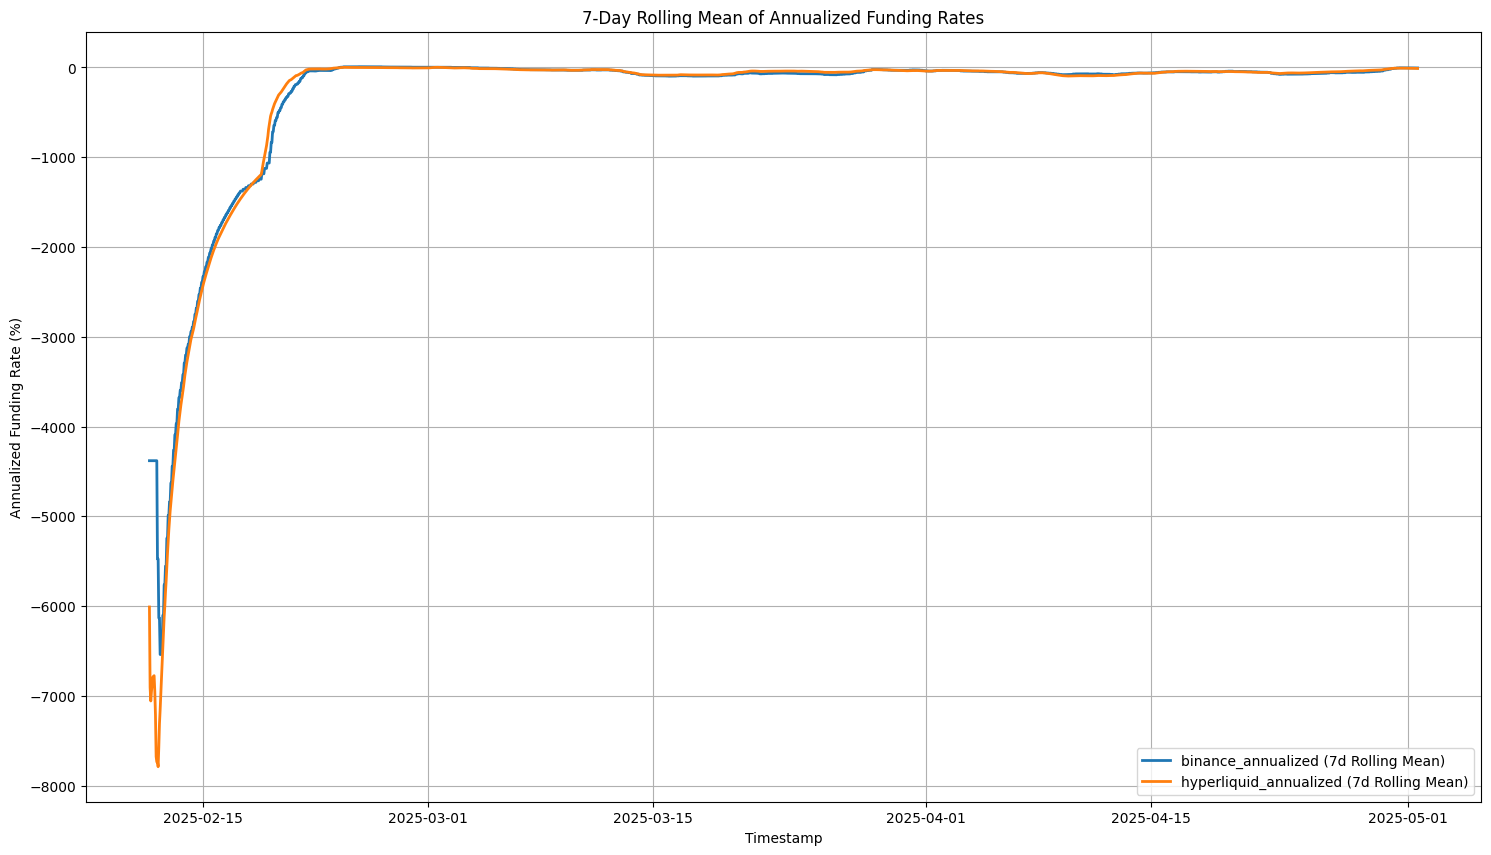

In [10]:
import matplotlib.pyplot as plt

# Define rolling window size (7 days = 168 hours)
rolling_window = 24 * 7

# Calculate 7-day rolling mean
rolling_means = (combined_df[annualized_cols].rolling(window=rolling_window, min_periods=1).mean()*100).round(2)

# Plot
plt.figure(figsize=(18, 10))
for col in annualized_cols:
    plt.plot(rolling_means.index, rolling_means[col], label=f"{col} (7d Rolling Mean)", linewidth=2)

plt.title('7-Day Rolling Mean of Annualized Funding Rates')
plt.xlabel('Timestamp')
plt.ylabel('Annualized Funding Rate (%)')
plt.grid(True)
plt.legend()
plt.show()
